In [2]:
import os
import sys
print("Python version: ", end=' ')
print(sys.version)

import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd
from scipy import sparse

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import seaborn as sns
sns.set_theme(style="whitegrid")
############# comment out below two lines on clusters ##########
%matplotlib inline
# %matplotlib notebook

################################################################
from glob import glob
timer = cy.timing.Timer()
time = timer.time

###### Local Import ######
sys.path.append('../../')
from greco_grb.scripts import SETTING
paths = SETTING.PATH()
print(paths)
LOCATION = paths.LOCATION
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from greco_grb.scripts.utils import *

print("\n===== Setting up csky =====\n")
data_dir = ICDATA_DIR
data_filenames = sorted(glob(data_dir + '/IC86_20*.data.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

################ energy lower bound #############
min_log_e = np.log10(10)
#################################################
bins_sindec = np.linspace(-1, 1, 25+1)  
bins_logenergy = np.linspace(min_log_e, 4, 25+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]
    
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.10', cascades=True)

ANA_DIR = cy.utils.ensure_dir(ANA_DIR)
# on OSG
# ana_dir = "./"
ana = cy.get_analysis(cy.selections.repo
                      , dataset_spec
                      , dir=ANA_DIR
                      , load_sig=True)  # false to save memory if needed 



Python version:  3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]

#### Working at GT ####

LOCATION: 	 GT
USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/candidate-002-p10
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output


===== Setting up csky =====

Setting up Analysis for:
greco_v2.10
Setting up greco_v2.10...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [3]:
df = pd.read_pickle(ANA_DIR+f"/unblind/result01.pkl").sort_values('post_p')
df.head(3)

,grb_name,grb_name_GBM,ra,dec,source_uncertainty,mjd_start,t100,t90,gbm,ra_source,...,pos_error_source,fluence,redshift,t_center,hasHealpix,tw,ts,ns,pre_p,post_p
1632,GRB140807A,GRB140807500,200.160000,26.490000,4.394479,56876.499692,0.000006,0.000006,1,Fermi_GBM,...,Fermi_GBM,1.286500e-06,NaN,56876.499695,True,100,19.469318,1.083586,0.000009,0.000046
1075,GRB160804D,GRB160804968,93.260000,-7.660000,9.065763,57604.967751,0.000002,0.000002,1,Fermi_GBM,...,Fermi_GBM,2.808000e-07,NaN,57604.967752,True,100,14.113972,2.808878,0.000197,0.000961
1079,GRB160802A,GRB160802259,28.029167,71.366667,0.441667,57602.259371,0.000209,0.000190,0,IPN,...,IPN,6.839900e-05,NaN,57602.259475,True,50,11.205534,2.735372,0.000260,0.001283


In [4]:
df[['grb_name', 'grb_name_GBM', 'ra', 'dec', 'source_uncertainty',
       'mjd_start','gbm', 'ra_source','hasHealpix','tw', 'ts', 'ns']].head(5)

,grb_name,grb_name_GBM,ra,dec,source_uncertainty,mjd_start,gbm,ra_source,hasHealpix,tw,ts,ns
1632,GRB140807A,GRB140807500,200.160000,26.490000,4.394479,56876.499692,1,Fermi_GBM,True,100,19.469318,1.083586
1075,GRB160804D,GRB160804968,93.260000,-7.660000,9.065763,57604.967751,1,Fermi_GBM,True,100,14.113972,2.808878
1079,GRB160802A,GRB160802259,28.029167,71.366667,0.441667,57602.259371,0,IPN,True,50,11.205534,2.735372
316,GRB190321A,GRB190321363,315.700000,6.620000,3.572227,58563.362889,1,Fermi_GBM,True,100,13.238818,1.795262
748,GRB170915A,GRB170915161,120.260000,-38.420000,2.710746,58011.160766,1,Fermi_GBM,True,100,9.440196,1.778291


In [5]:
grb_name='GRB170915A'
from astropy.time import Time
t = Time(df[df.grb_name==grb_name]['mjd_start'].values[0], format='mjd')
t.iso


'2017-09-15 03:51:30.157'

In [6]:
0.004192*86400

362.1888

In [41]:
import argparse
class args:
    def __init__(self, 
                 grb_name="GRB140807A", 
                 tw_in_second=100, 
                 ncpu=4, 
                 n_injs=np.round(np.r_[0:9.1:0.2], 2)):
        self.grb_name = grb_name
        self.tw_in_second = tw_in_second
        self.ncpu = ncpu
        self.n_injs = n_injs
##########################

In [42]:
def get_tr(info, gamma=2.5):
    args = info
    df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")
    try:
        healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format(args.grb_name))
        # healpix can contain negative values: faults due to Fermi-GBM
        healpix = np.maximum(healpix,0)
        ########## healpix reduce (< instead of <=) ##########
        healpix[healpix < isf_healpix(healpix, q=0.99)] = 0
    except:
        raise Exception("Cannot load the healpix for grb: {}\n".format(args.grb_name))
    grb_row = df.loc[df['grb_name'] == args.grb_name]
    tw = args.tw_in_second/86400.
    tw_start = grb_row.t_center - 0.5*tw
    ra = grb_row.ra
    dec = grb_row.dec
    #### used for spatial prior trial_runner
    conf = {
        'ana': ana,
        #### llh basics: csky.conf
        'space': 'prior', # ps/fitps/template/prior
        'time': 'transient', # utf/lc/transient
        'energy': 'customflux', # fit/customflux
        'flux': cy.hyp.PowerLawFlux(gamma),
        #### inj.py - prior has some duplications against space's prior
        'sig': 'transient', # ps/tw/lc/transient/template/prior
        'full_sky': True,
        'extended': True,
        'mp_cpus': args.ncpu,
        'cut_n_sigma': 3
    }
    cy.CONF.update(conf)
    src = cy.sources(
        ra=ra,
        dec=dec,
        deg=True,
        mjd=tw_start, 
        sigma_t=np.zeros_like(tw), 
        t_100=tw,  # in days
        prior=[hl.heal.HealHist(healpix)],
        name=args.grb_name
    )
    tr = cy.get_trial_runner(conf=cy.CONF, ana=ana, src=src
                                 ,llh_priors=[healpix]
                                 ,cut_n_sigma=3.)
#     tr = cy.get_spatial_prior_trial_runner(conf=cy.CONF
#                                              ,src_tr=src
#                                              ,llh_priors=[healpix]
#                                              ,cut_n_sigma=3.)
    return tr

In [43]:
def get_upper_limit(info, the_ts, gamma=2.5, use_first=None, n_bootstrap=1):
    args = info
    df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")
    try:
        healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format(args.grb_name))
        # healpix can contain negative values: faults due to Fermi-GBM
        healpix = np.maximum(healpix,0)
        ########## healpix reduce (< instead of <=) ##########
        healpix[healpix < isf_healpix(healpix, q=0.99)] = 0
    except:
        raise Exception("Cannot load the healpix for grb: {}\n".format(args.grb_name))
    grb_row = df.loc[df['grb_name'] == args.grb_name]
    tw = args.tw_in_second/86400.
    tw_start = grb_row.t_center - 0.5*tw
    ra = grb_row.ra
    dec = grb_row.dec
    
    #### used for spatial_prior_trial_runner
    conf = {
        'ana': ana,
        #### llh basics: csky.conf
        'space': 'ps', # ps/fitps/template/prior
        'time': 'transient', # utf/lc/transient
        'energy': 'customflux', # fit/customflux
        'flux': cy.hyp.PowerLawFlux(gamma),
        #### inj.py - prior has some duplications against space's prior
        'sig': 'transient', # ps/tw/lc/transient/template/prior
        'full_sky': True,
        'extended': True,
        'mp_cpus': args.ncpu,
        'cut_n_sigma': 3
        }
    cy.CONF.update(conf)
#     bg_files = glob(ANA_DIR+"/allsky_scan/with_prior_background/tw{}/{}*.npz".format(args.tw_in_second, args.grb_name))
#     if use_first is None:
#         bg = cy.dists.Chi2TSD(np.ravel([sparse.load_npz(bg_file).toarray() for bg_file in bg_files]))
#     else:
#         bg = cy.dists.Chi2TSD(np.ravel([sparse.load_npz(bg_file).toarray() for bg_file in bg_files])[:use_first])
    
    n_injs = args.n_injs
    sig = {}
    for n_inj in n_injs:
        sig_files = glob(ANA_DIR+"/prior_injection/gamma_{:.2f}/tw{}/{}/{}*{:.1f}.npy".format(
            gamma,
            args.tw_in_second, 
            args.grb_name, 
            args.grb_name,
            n_inj))
        sig[n_inj] = cy.utils.Arrays(np.ravel([np.load(sig_file) for sig_file in sig_files]))
    trials = sig
#     trials.update({0: bg.trials})
    src = cy.sources(
        ra=ra,
        dec=dec,
        deg=True,
        mjd=tw_start, 
        sigma_t=np.zeros_like(tw), 
        t_100=tw,  # in days
        prior=[hl.heal.HealHist(healpix)],
        name=args.grb_name
    )
    sptr = cy.get_spatial_prior_trial_runner(conf=cy.CONF
                                             ,src_tr=src
                                             ,llh_priors=[healpix]
                                             ,cut_n_sigma=3.) # src_tr is must for transient
    
    upper_limit = sptr.find_n_sig(ts=the_ts,
                                 beta=0.9,
                                 max_batch_size=0, 
                                   logging=False, 
                                   trials=trials, n_bootstrap=n_bootstrap)
    return upper_limit
    

In [52]:
from astropy import units as u
grb_name = "GRB190114C"
gamma = 2.5
tw_in_second = 500
# tw_in_second = df[df.grb_name==grb_name]['tw'].values[0]
the_ts = df[df.grb_name==grb_name]['ts'].values[0]
ag = args(grb_name=grb_name,tw_in_second=tw_in_second)
upper_limit = get_upper_limit(ag, the_ts=the_ts, 
                              gamma=gamma, use_first=None)
tr = get_tr(ag, gamma=gamma)
E0, unit = 100, 1
print(f"gamma is {gamma}")
print(f"tw_in_second is {tw_in_second} s")
print(f"the_ts is {the_ts}")
E2dNdE = tr.to_E2dNdE(upper_limit['n_sig'], E0=E0, unit=unit) * 1e9 * u.eV / u.cm / u.cm
print(f"E2dNdE is {E2dNdE}")
E2dNdEdt = (E2dNdE / (tw_in_second * u.s)).to(u.erg/(u.cm*u.cm*u.s))
print(f"E2dNdEdt is {E2dNdEdt:E}")

gamma = 2.0
the_ts = df[df.grb_name==grb_name]['ts'].values[0]
ag = args(grb_name=grb_name,tw_in_second=tw_in_second)
upper_limit = get_upper_limit(ag, the_ts=the_ts, 
                              gamma=gamma, use_first=None)
tr = get_tr(ag, gamma=gamma)
print(f"gamma is {gamma}")
print(f"tw_in_second is {tw_in_second} s")
print(f"the_ts is {the_ts}")
E2dNdE = tr.to_E2dNdE(upper_limit['n_sig'], E0=E0, unit=unit) * 1e9 * u.eV / u.cm / u.cm
print(f"E2dNdE is {E2dNdE}")
E2dNdEdt = (E2dNdE / (tw_in_second * u.s)).to(u.erg/(u.cm*u.cm*u.s))
print(f"E2dNdEdt is {E2dNdEdt:E}")

gamma is 2.5
tw_in_second is 500 s
the_ts is 0.0
E2dNdE is 3452638829.7817135 eV / cm2
E2dNdEdt is 1.106347E-05 erg / (cm2 s)
gamma is 2.0
tw_in_second is 500 s
the_ts is 0.0
E2dNdE is 2143928723.5464873 eV / cm2
E2dNdEdt is 6.869905E-06 erg / (cm2 s)


In [53]:
from scipy import stats
stats.norm.sf(3)

0.0013498980316300933

In [54]:
def get_energy_limit(info, gamma=2.0, runs=1000000):
    args = info
    df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")
    try:
        healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format(args.grb_name))
        # healpix can contain negative values: faults due to Fermi-GBM
        healpix = np.maximum(healpix,0)
        ########## healpix reduce (< instead of <=) ##########
        healpix[healpix < isf_healpix(healpix, q=0.99)] = 0
    except:
        raise Exception("Cannot load the healpix for grb: {}\n".format(args.grb_name))
    grb_row = df.loc[df['grb_name'] == args.grb_name]
    tw = args.tw_in_second/86400.
    tw_start = grb_row.t_center - 0.5*tw
    ra = grb_row.ra
    dec = grb_row.dec
    conf = {
        'ana': ana,
        #### llh basics: csky.conf
        'space': 'ps', # ps/fitps/template/prior
        'time': 'transient', # utf/lc/transient
        'energy': 'customflux', # fit/customflux
        'flux': cy.hyp.PowerLawFlux(gamma),
        #### inj.py - prior has some duplications against space's prior
        'sig': 'transient', # ps/tw/lc/transient/template/prior
        'full_sky': True,
        'extended': True,
        'mp_cpus': args.ncpu,
        'cut_n_sigma': 3
        }
    cy.CONF.update(conf)
    
    src = cy.sources(
            ra=ra,
            dec=dec,
            deg=True,
            mjd=tw_start, 
            sigma_t=np.zeros_like(tw), 
            t_100=tw,  # in days
            prior=[hl.heal.HealHist(healpix)],
            name=args.grb_name
        )
    sptr = cy.get_spatial_prior_trial_runner(conf=cy.CONF
                                             ,src_tr=src
                                             ,llh_priors=[healpix]
                                             ,cut_n_sigma=3.) # src_tr is must for transient
    events = sptr.get_one_trial(n_sig=runs)
    print(events)
    energies = 10 ** events[0][0][1].log10energy
    plt.hist(events[0][0][1].log10energy)
    return np.quantile(energies, [0.1, 0.9])

SpatialPriorTrial(evss=[[Events(1 items | columns: azimuth, dec, energy, idx, inj, log10energy, mjd, ra, sigma, sindec), Events(1000000 items | columns: azimuth, dec, idx, inj, log10energy, mjd, ra, sigma, sindec)]], n_exs=[0], ra=array([0.95720401]), dec=array([-0.48787515]))


array([ 41.09723282, 995.40740967])

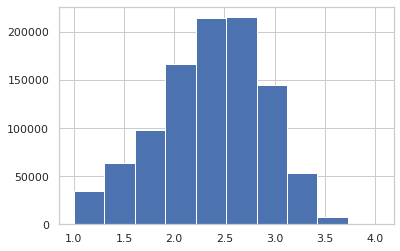

In [24]:
# ag = args(grb_name="GRB190114C",tw_in_second=500)
# get_energy_limit(ag, gamma=2.0, runs=1000000)

In [25]:
# np.log10([ 41.09723282, 995.40740967])

array([1.61381258, 2.99800087])

In [61]:
log10xrange = np.array([1.6104759, 2.99592328])
xrange = 10**log10xrange * 1e9
x = 10**np.mean(log10xrange) *1e9
y = 6.869905E-06
xerr = np.abs(xrange - x)[:,None]

In [62]:
tmp_style = {
    'text.usetex' : False,
    'mathtext.rm' : 'Times New Roman',
    'mathtext.it' : 'Times New Roman:italic',
    'mathtext.bf' : 'Times New Roman:bold',
    'mathtext.fontset': 'stix',
    'axes.titlesize' : 20,
    'xtick.labelsize' : 16,
    'ytick.labelsize' : 14,
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'xtick.minor.size' : 3,
    'ytick.minor.size' : 3,
    'axes.labelsize' : 20,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'ytick.left' : True,
    'ytick.right' : True,
    'xtick.top' : True,
    'axes.grid' : True,
    'axes.grid.which' : 'major',
    'axes.linewidth': 1.5,
    'grid.color' : 'lightgrey',
    'grid.alpha' : 0.4,
    'grid.linewidth' : 0.75,
    'lines.linewidth' : 1.5,
    'font.size' : 16,
    'image.cmap': 'PuBu',
}

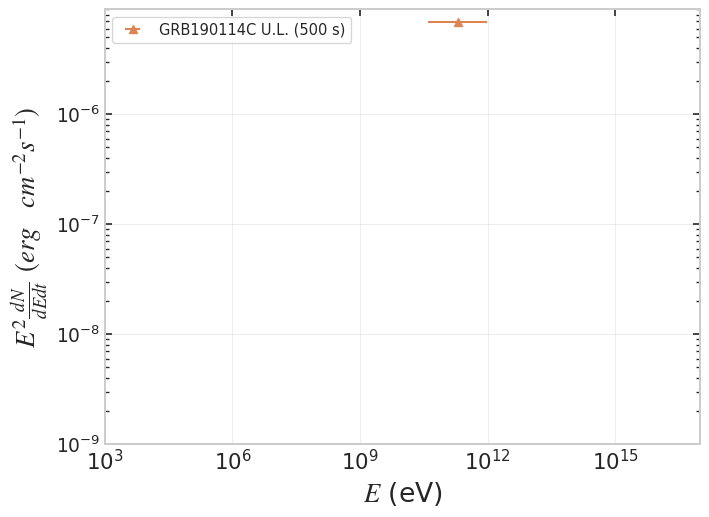

In [63]:
with mpl.rc_context(tmp_style):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=96)
    ax.errorbar(x, y, xerr=xerr, fmt='^', color=sns.color_palette()[1], label="GRB190114C U.L. (500 s)")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1e3, 1e17)
    ax.set_ylim(1e-9, 9e-6)
    ax.set_xticks(np.r_[1e3,1e6,1e9,1e12,1e15])
    locmajy = mpl.ticker.LogLocator(base=10,numticks=100) 
    ax.yaxis.set_major_locator(locmajy)
    locminy = mpl.ticker.LogLocator(base=10,subs=np.arange(2, 10) * .1,numticks=100)
    ax.yaxis.set_minor_locator(locminy)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    ax.set_xlabel(r"$E$ (eV)")
    ax.set_ylabel(r"$E^2 \frac{dN}{dEdt}$ $(erg \quad cm^{-2} s^{-1})$ ")
    ax.legend()
    plt.show()

In [64]:
#### #### #### From @apizzuto #### #### #### 

#### BEGIN WITH 190114C LIMITS ####
import scipy as sp
gev_to_erg = 0.00160218
icecube_delta_t = 3750.
icecube_lim = 3.5e-01 * gev_to_erg / icecube_delta_t
icecube_es = np.array([8e4, 2e7]) * 1e9
mid_icecube_e = 10.**np.mean(np.log10(icecube_es))

icecube_sens =3.5e-2 * gev_to_erg / icecube_delta_t
icecube_sens_es = np.array([1e3, 5e6]) * 1e9
mid_icecube_sens_e = 10.**np.mean(np.log10(icecube_sens_es))

antares_delta_t = 1600.
antares_es = np.array([1e4, 2e7]) * 1e9
antares_lim = 1.6 * gev_to_erg / antares_delta_t
mid_antares_e = 10.**np.mean(np.log10(antares_es))

def load_band(e_range, time_window):
    low_edge = np.genfromtxt('/storage/home/hhive1/cchen641/icecube/references/apizzuto/dump/grb190114c_data/time_window_{}_{}_bottom.csv'.format(time_window, e_range),
             delimiter=', ')
    high_edge = np.genfromtxt('/storage/home/hhive1/cchen641/icecube/references/apizzuto/dump/grb190114c_data/time_window_{}_{}_top.csv'.format(time_window, e_range),
             delimiter=', ')
#     low_edge = np.genfromtxt('/data/user/apizzuto/fast_response_skylab/dump/grb190114c_data/time_window_{}_{}_bottom.csv'.format(time_window, e_range),
#              delimiter=', ')
#     high_edge = np.genfromtxt('/data/user/apizzuto/fast_response_skylab/dump/grb190114c_data/time_window_{}_{}_top.csv'.format(time_window, e_range),
#              delimiter=', ')
    low_spl = sp.interpolate.UnivariateSpline(np.log10(low_edge.T[0]), np.log10(low_edge.T[1]))
    high_spl = sp.interpolate.UnivariateSpline(np.log10(high_edge.T[0]), np.log10(high_edge.T[1]))
    low_e = np.max([low_edge.T[0].min(), high_edge.T[0].min()])
    high_e = np.min([low_edge.T[0].max(), high_edge.T[0].max()])
    es = np.linspace(low_e, high_e, 500)
    return es, 10.**low_spl(np.log10(es)), 10.**high_spl(np.log10(es))
def load_bands(time_window):
    low = load_band('low', time_window)
    med = load_band('med', time_window)
    high = load_band('hi', time_window)
    return low, med, high
def load_points(time_window):
    data = np.genfromtxt('/storage/home/hhive1/cchen641/icecube/references/apizzuto/dump/grb190114c_data/time_window_{}_data.csv'.format(time_window),
             delimiter=', ')
    xerr0 = np.genfromtxt('/storage/home/hhive1/cchen641/icecube/references/apizzuto/dump/grb190114c_data/time_window_{}_left.csv'.format(time_window),
             delimiter=', ').T[0]
    xerr1 = np.genfromtxt('/storage/home/hhive1/cchen641/icecube/references/apizzuto/dump/grb190114c_data/time_window_{}_right.csv'.format(time_window),
             delimiter=', ').T[0] 
    yerr0 = np.genfromtxt('/storage/home/hhive1/cchen641/icecube/references/apizzuto/dump/grb190114c_data/time_window_{}_down.csv'.format(time_window),
             delimiter=', ').T[1]
    yerr1 = np.genfromtxt('/storage/home/hhive1/cchen641/icecube/references/apizzuto/dump/grb190114c_data/time_window_{}_up.csv'.format(time_window),
             delimiter=', ').T[1]
#     data = np.genfromtxt('/data/user/apizzuto/fast_response_skylab/dump/grb190114c_data/time_window_{}_data.csv'.format(time_window),
#              delimiter=', ')
#     xerr0 = np.genfromtxt('/data/user/apizzuto/fast_response_skylab/dump/grb190114c_data/time_window_{}_left.csv'.format(time_window),
#              delimiter=', ').T[0]
#     xerr1 = np.genfromtxt('/data/user/apizzuto/fast_response_skylab/dump/grb190114c_data/time_window_{}_right.csv'.format(time_window),
#              delimiter=', ').T[0] 
#     yerr0 = np.genfromtxt('/data/user/apizzuto/fast_response_skylab/dump/grb190114c_data/time_window_{}_down.csv'.format(time_window),
#              delimiter=', ').T[1]
#     yerr1 = np.genfromtxt('/data/user/apizzuto/fast_response_skylab/dump/grb190114c_data/time_window_{}_up.csv'.format(time_window),
#              delimiter=', ').T[1]
    return data, [data.T[0] - xerr0, xerr1 - data.T[0]], [data.T[1] - yerr0, yerr1 - data.T[1]]

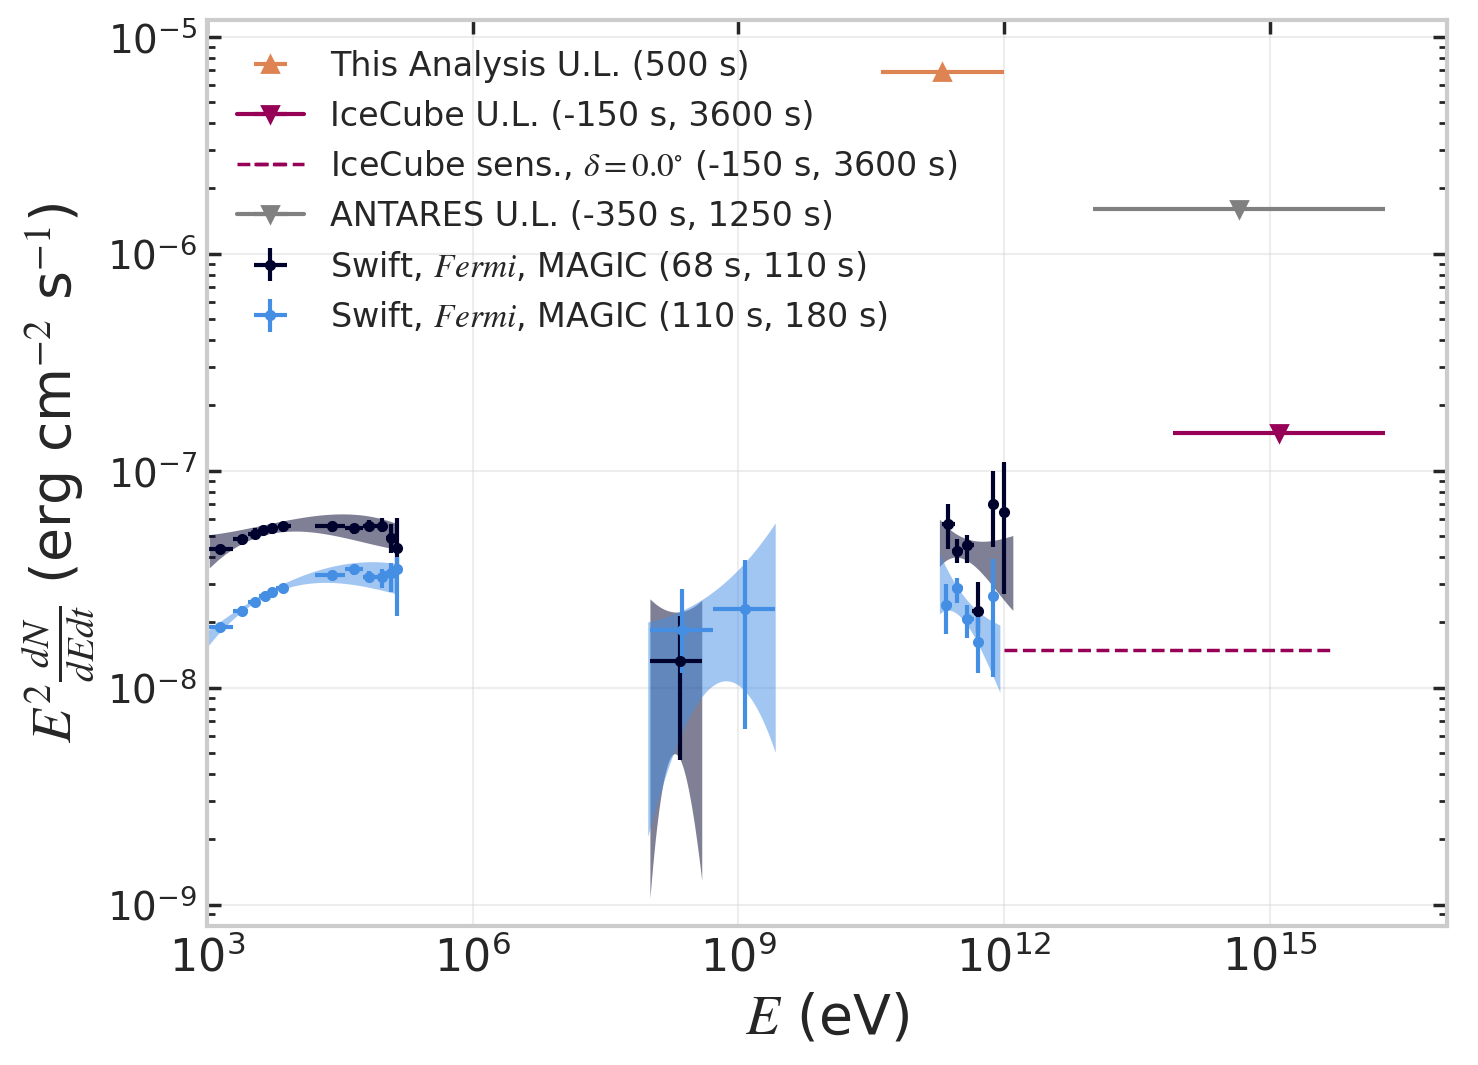

In [65]:
with mpl.rc_context(tmp_style):
    fig = plt.figure(figsize=(8, 6), dpi=200)
    bin_width = np.sqrt(10.)
    fig.set_facecolor('w')
    ####### This analysis for GRB190114C ###########
    plt.errorbar(x, y, xerr=xerr, fmt='^', color=sns.color_palette()[1], label="This Analysis U.L. (500 s)")
    ###############################################
    
    #plt.errorbar(ens, sens,  xerr=[ens-ens/bin_width, ens*bin_width-ens],
    #                marker='v', ls=':', color=sns.xkcd_rgb['dark sky blue'])
    plt.errorbar([mid_icecube_e], [icecube_lim], xerr=[np.array([mid_icecube_e]) - icecube_es[0],
                        -1.*np.array([mid_icecube_e]) + icecube_es[1]],
                        marker='v', color=sns.xkcd_rgb['dark magenta'], 
                         label = 'IceCube U.L. (-150 s, 3600 s)')

    eb=plt.errorbar([mid_icecube_sens_e], [icecube_sens], xerr=[np.array([mid_icecube_sens_e]) - icecube_sens_es[0],
                        -1.*np.array([mid_icecube_sens_e]) + icecube_sens_es[1]], lw=1.25,
                        marker='v', color=sns.xkcd_rgb['dark magenta'], markersize=0., ls='--',
                         label = 'IceCube sens., ' + r'$\delta=0.0^{\circ}$ (-150 s, 3600 s)')
    eb[-1][0].set_linestyle('--')

    plt.errorbar([mid_antares_e], [antares_lim], xerr=[np.array([mid_antares_e]) - antares_es[0],
                        -1.*np.array([mid_antares_e]) + antares_es[1]],
                        marker='v', color='grey', label = 'ANTARES U.L. (-350 s, 1250 s)')

    cols = [sns.xkcd_rgb['dark navy blue'], sns.xkcd_rgb['dark sky blue']] #dark sky blue, deep sky blue
    time_strs = ['Swift, $\it{Fermi}$, MAGIC (68 s, 110 s)', 'Swift, $\it{Fermi}$, MAGIC (110 s, 180 s)']
    for ii, time_window in enumerate([1, 2]):
        ds, xerr, yerr = load_points(time_window)
        plt.errorbar(ds.T[0], ds.T[1], xerr=xerr, yerr=yerr, ls='', 
                     marker='o', markersize=3, color = cols[ii], label=time_strs[ii])
        bands = load_bands(time_window)
        for band in bands:
            plt.fill_between(band[0], band[1], band[2], alpha=0.5, 
                             color = cols[ii], lw=0.)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(0.8e-9, 1.2e-5)
    plt.xlim(1e3, 1e17)
    plt.legend(loc='upper left', fontsize=12, ncol=1, frameon=False)
    plt.xlabel(r'$E$ (eV)')
    plt.xticks(np.logspace(3, 15, 5))
    #if ii == 0:
    plt.ylabel(r'$E^2 \frac{dN}{dEdt}$ (erg cm$^{-2}$ s$^{-1}$)')